<a href="https://colab.research.google.com/github/gashawmg/Avalon-fingerprints-for-machine-learning/blob/main/Avalon%20fingerprints%20for%20predictive%20modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="background-color:lightgreen; border-style: dotted;border-color: yellow;text-align:center;color:blue;font-size:20px;border-radius: 50px;padding: 20px 20px;"><strong> Gashaw M. Goshu, Ph.D. in Chemistry</strong></div>

In [44]:
!!pip install rdkit-pypi==2022.3.1.1

['Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/',
 'Requirement already satisfied: rdkit-pypi==2022.3.1.1 in /usr/local/lib/python3.8/dist-packages (2022.3.1.1)',
 'Requirement already satisfied: Pillow in /usr/local/lib/python3.8/dist-packages (from rdkit-pypi==2022.3.1.1) (7.1.2)',
 'Requirement already satisfied: numpy in /usr/local/lib/python3.8/dist-packages (from rdkit-pypi==2022.3.1.1) (1.21.6)']

#### In the previous [molecular fingerprints video](https://www.youtube.com/watch?v=-oHqQBUyrQ0), we saw how to generate molecular fingerprints and use them for structure search.

#### In this notebook, I will use Avalon fingerprints to develop predictive models for molecular property (energy gap) and reactions outcome (yield and enantioselectivity).
* HOMO-LUMO energy gap of organic compouds
* Yield Prediction of C–N cross coupling reactions
* Catalytic enantioselectivity of thiol-imine reactions

<div>
    <img src = "Fingerprints_predictive.JPG", width="600">
</div>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#-------------------------------------------------------
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.DataStructs.cDataStructs import ExplicitBitVect
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import PandasTools
from rdkit.Chem import rdMolDescriptors
from tqdm import tqdm
#--------------------------------------------------------
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import time
from sklearn.model_selection import ShuffleSplit, cross_validate,train_test_split
#--------------------------------------------------------
from lightgbm import LGBMRegressor

### Dataset obtained [Sandfort et al.](https://zivgitlab.uni-muenster.de/m_kueh11/fp-dm-tool).


<div style= " border-style:dotted;text-align:left;color:blue;font-size:25px;border-radius: 10px;padding: 20px 20px;">
1. HOMO-LUMO energy gap of molecules. 

</div>


In [3]:
# Reference for the datasets: https://zivgitlab.uni-muenster.de/m_kueh11/fp-dm-tool
# but, I converted excel files to csv files 

dataset = pd.read_csv("https://raw.githubusercontent.com/gashawmg/Avalon-fingerprints-for-machine-learning/main/Orbital_Energies_input_data.csv")
dataset.head()

,SMILES,Energygap
0,Cc1ccc(cc1)C(F)(F)F,197.749421
1,OC(=O)CCCCl,247.493942
2,CC(C)(Oc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1)C(=O)O,164.712327
3,Nc1ccc(Cl)c(Cl)c1,169.027707
4,C[C@@H](CCO)CCC=C(C)C,209.569808


In [4]:
dataset.shape

(2904, 2)

In [5]:
# Include 2D structure of molecules
PandasTools.AddMoleculeColumnToFrame(dataset,'SMILES','Stucture',includeFingerprints=True)

,SMILES,Energygap,Stucture
0,Cc1ccc(cc1)C(F)(F)F,197.749421,
1,OC(=O)CCCCl,247.493942,
2,CC(C)(Oc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1)C(=O)O,164.712327,
3,Nc1ccc(Cl)c(Cl)c1,169.027707,
4,C[C@@H](CCO)CCC=C(C)C,209.569808,

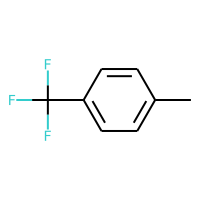
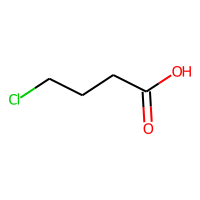
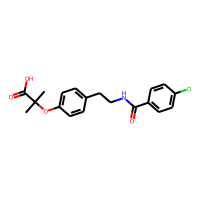
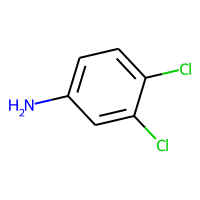
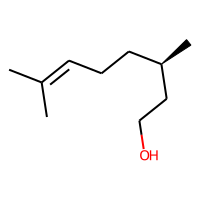

In [6]:
dataset.head()

<div style= " border-style:dotted;text-align:left;color:purple;font-size:20px;border-radius: 10px;padding: 20px 20px;"> 
    
* Function defination for generating Avalon molecular fingerprints using RDKit
</div>

In [7]:
def generate_AVfpts(data):
    
    # Store fingerprints using empty lists
    
    Avalon_fpts = []
    
    # Here no need to generate mol files
    # We can directly use the structure column of the data frame
    # mols = [Chem.MolFromSmiles(x) for x in data if x is not None]
    for mol in tqdm(data):
      
               
        #=============================
        # calculate Avalon fingerprints
        #=============================
        avfpts = pyAvalonTools.GetAvalonFP(mol, nBits=4096)
        Avalon_fpts.append(avfpts)
        
        
    #=====append=========================
    # return the lists as numpy array 
    #====================================
    return np.array(Avalon_fpts)

<div style= "border-style:dotted;text-align:left;color:darkblue;font-size:20px;border-radius: 10px;padding: 20px 20px;"> 
    
* Function call to generate Avalon molecular fingerprints of compounds that have HOMO-LUMO energy gap.
</div>

In [8]:
# Function call
Avalon_fpts = generate_AVfpts(dataset['Stucture'])

100%|██████████| 2904/2904 [00:03<00:00, 898.46it/s]


### Put the fingerprints in dataframe

In [9]:
# Put Avalon fingerprints into Dataframe
Avalon_fingerprints = pd.DataFrame(Avalon_fpts, columns=['Col_A_{}'.format(i + 1) 
                                                        for i in range(Avalon_fpts.shape[1])])

In [10]:
Avalon_fingerprints.head()

,Col_A_1,Col_A_2,Col_A_3,Col_A_4,Col_A_5,Col_A_6,Col_A_7,Col_A_8,Col_A_9,Col_A_10,...,Col_A_4087,Col_A_4088,Col_A_4089,Col_A_4090,Col_A_4091,Col_A_4092,Col_A_4093,Col_A_4094,Col_A_4095,Col_A_4096
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Instantiate the models
lgbm_av = LGBMRegressor(n_estimators=800, random_state=42)
model_rf = RandomForestRegressor(random_state=42)

<div style= "border-style:dotted;text-align:left;color:darkblue;font-size:20px;border-radius: 10px;padding: 20px 20px;"> 
10 fold cross-validation using 4,096 bits of Avalon fingerprints
</div>

In [12]:
# start time
start = time.time()

# tenfold cross-validation
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
scoring = ['r2','neg_mean_absolute_error']

scores_val = cross_validate(lgbm_av, Avalon_fingerprints,  dataset.Energygap, scoring=scoring, cv=cv)

print(scores_val)

time.sleep(3)
# get the end time
end = time.time()

# get the execution time
total_time = end - start
print('Total time required:', round(total_time/60, 2), 'min')

{'fit_time': array([13.80875468, 10.88797569,  7.68041158,  7.28431368,  7.30712271,
        7.0737493 ,  7.37690115,  7.4414885 ,  7.18708992,  7.05793071]), 'score_time': array([0.12490869, 0.1180861 , 0.12381482, 0.12389135, 0.12419438,
       0.12785649, 0.13586164, 0.12710357, 0.1310432 , 0.13964272]), 'test_r2': array([0.91044654, 0.90800796, 0.91153183, 0.92018218, 0.9045963 ,
       0.89865031, 0.90671041, 0.90788038, 0.89827042, 0.91485459]), 'test_neg_mean_absolute_error': array([-5.79133628, -5.82072238, -5.86919926, -5.52286442, -6.21463951,
       -6.16613145, -5.97132058, -6.12992087, -5.94971449, -5.76417806])}
Total time required: 1.46 min


In [13]:
# R^2 of coefficient of determination of tenfold cross validation
scores_val['test_r2']

array([0.91044654, 0.90800796, 0.91153183, 0.92018218, 0.9045963 ,
       0.89865031, 0.90671041, 0.90788038, 0.89827042, 0.91485459])

In [14]:
# Mean absolute error (MAE) of the tenfold cross validation values
-scores_val['test_neg_mean_absolute_error']

array([5.79133628, 5.82072238, 5.86919926, 5.52286442, 6.21463951,
       6.16613145, 5.97132058, 6.12992087, 5.94971449, 5.76417806])

In [15]:
# Mean values of tenfold cross-validation values of R^2 and MAE 
# Using lightGBM

print("R^2 :", round(np.mean(scores_val['test_r2']), 2))
print("MAE :", round(np.mean(-scores_val['test_neg_mean_absolute_error']), 2))

R^2 : 0.91
MAE : 5.92


Compared with published result: [Sandfort et al's](https://www.sciencedirect.com/science/article/pii/S2451929420300851) work.
<div>
    <img src="https://github.com/gashawmg/Avalon-fingerprints-for-machine-learning/blob/main/HUMO_LUMO.JPG?raw=1", align = "left", width = "500">
    </div

[ See supporting information of the paper ](https://zivgitlab.uni-muenster.de/m_kueh11/fp-dm-tool)
.Note this information is found on page 5 in the supporting information 

<div>
<img src= "Feature Preprocessing.JPG",align = "left", width = "600" />
 </div>

## 1.  Train-test data split  for Avalon fingerprints

In [16]:
X_train_av, X_test_av, y_train_av, y_test_av = train_test_split(Avalon_fingerprints,
                                                    dataset.Energygap,test_size=0.3,random_state=42)

In [17]:
# Model training and test
model_av = lgbm_av.fit(X_train_av,y_train_av)
predict_av = model_av.predict(X_test_av)

In [18]:
# Model performance using MAE
MAE_av = mean_absolute_error(y_test_av, predict_av)
print('MAE:', round(MAE_av,2))

MAE: 5.79


In [19]:
# R^2 (coefficient of determination) regression score function: 
R2_av =r2_score(y_test_av, predict_av)
print('R^2:', round(R2_av,2))

R^2: 0.91


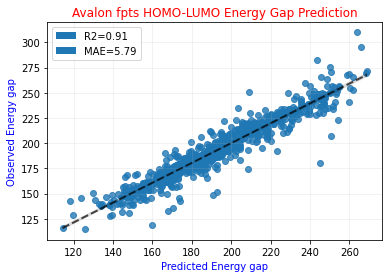

In [20]:
sns.regplot(x=predict_av, y=y_test_av,line_kws={"lw":2,'ls':'--','color':'black',"alpha":0.7})
plt.xlabel('Predicted Energy gap', color='blue')
plt.ylabel('Observed Energy gap', color ='blue')
plt.title("Avalon fpts HOMO-LUMO Energy Gap Prediction", color='red')
plt.grid(alpha=0.2)
R2_av = mpatches.Patch(label="R2={:04.2f}".format(R2_av))
MAE_av = mpatches.Patch(label="MAE={:04.2f}".format(MAE_av))
plt.legend(handles=[R2_av, MAE_av])

<div style= " border-style:dotted;text-align:left;color:blue;font-size:25px;border-radius: 10px;padding: 20px 20px;">
2. Yield Prediction:
C–N cross coupling reactions
</div>

Reference:[Ahneman et al](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C14&q=Predicting+reaction+performance+in+C%E2%80%93N+cross-coupling+using+machine+learning&btnG=).
and [for supplemental information](https://www.science.org/doi/abs/10.1126/science.aar5169)

<div>
    <img src="https://github.com/gashawmg/Avalon-fingerprints-for-machine-learning/blob/main/buchwald.JPG?raw=1" width="700",align ="left"/>
</div>

* Used 1536 plate (3 plates => 3 x 1536 (32 x 48)  = 4608)
* Removed control reactions and additive 7 
* 3,960 reactions were used for machine learning.
* Determined yield UPLC, di-tert-butylbiphenyl as internal standard (probably using response factor)
### Computed Descriptors (120)
* B3LYP/6-31G*
### Calculated various descriptors: 
* electrostatic charge and NMR shift.
* molecular volume, 
* surface area, ovality, molecular weight, HOMO,  
* LUMO, electronegativity, hardness, dipole moment,
* frequency and intensity.

### Generated 120 computed descriptors
* Additive Descriptors (19)
* Aryl Halide Descriptors ( 27)
* Base Descriptors (10)
* Ligand Descriptors (64)

<div>
    <img src="https://github.com/gashawmg/Avalon-fingerprints-for-machine-learning/blob/main/Buchwald_RF.JPG?raw=1" width="600",align ="left"/>
</div>


There was an excel file that I downloaded converted it to csv file from this reference. [Sandfort et al](https://zivgitlab.uni-muenster.de/m_kueh11/fp-dm-tool). 

In [21]:
# Read data frame
data = pd.read_csv('https://raw.githubusercontent.com/gashawmg/Avalon-fingerprints-for-machine-learning/main/Buchwald_yield_data.csv')
data

,Ligand,Additive,Base,Aryl halide,Output
0,CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[...,CC1=CC(C)=NO1,CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC,ClC1=NC=CC=C1,70.410458
1,CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[...,O=C(OC)C1=CC=NO1,CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC,BrC1=NC=CC=C1,11.064457
2,CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)...,O=C(OC)C1=CC=NO1,CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC,IC1=CC=C(CC)C=C1,10.223550
3,CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C(C)(C)C)...,CCOC(C1=CON=C1)=O,CN1CCCN2C1=NCCC2,ClC1=CC=C(C(F)(F)F)C=C1,20.083383
4,CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[...,CC1=CC(C)=NO1,CN1CCCN2C1=NCCC2,ClC1=CC=C(OC)C=C1,0.492663
...,...,...,...,...,...
3950,CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C3CCCCC3)...,C1(C2=CC=CC=C2)=CON=C1,CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC,BrC1=CC=C(OC)C=C1,4.344677
3951,CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C(C)(C)C)...,CC1=CC(N2C=CC=C2)=NO1,CN1CCCN2C1=NCCC2,BrC1=CC=C(OC)C=C1,47.156275
3952,CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P(C(C)(C)C)...,CCOC(C1=CON=C1)=O,CC(C)(C)/N=C(N(C)C)/N(C)C,ClC1=CC=C(C(F)(F)F)C=C1,0.701552
3953,CC(C)C(C=C(C(C)C)C=C1C(C)C)=C1C2=C(P([C@@]3(C[...,C1(N(CC2=CC=CC=C2)CC3=CC=CC=C3)=CC=NO1,CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC,ClC1=CC=C(C(F)(F)F)C=C1,15.561565


In [22]:
def Calculate_Avfps(data,nBits):
    
    # Store fingerprints using empty lists
    Avalon_fpts = []
           
    mols = [Chem.MolFromSmiles(x) for x in data if x is not None]
    for mol in tqdm(mols):
        
               
        #=============================
        # calculate Avalon fingerprints
        #=============================
        avfpts = pyAvalonTools.GetAvalonFP(mol, nBits=nBits)
        Avalon_fpts.append(avfpts)
        
       
    #=================================
    # return the lists as numpy array 
    #=================================
    return np.array(Avalon_fpts)

## Calculate fingerprints for reactants

In [23]:
ligand_fpts =  Calculate_Avfps(data['Ligand'], 2048) # ligands are relatively bigger than the other reagents
additive_fpts =  Calculate_Avfps(data['Additive'], 1024)
base_fpts =  Calculate_Avfps(data['Base'], 1024)
Aryl_fpts =  Calculate_Avfps(data['Aryl halide'], 1024)

100%|██████████| 3955/3955 [00:01<00:00, 3272.64it/s]


## Concatenate fingerprints of starting materials
Similar to [Sandfort et al's](https://www.sciencedirect.com/science/article/pii/S2451929420300851) work.

In [24]:
# concatenate the fingerprints of the four variables 
# note that the order of concatenation should not matter

concatenated = np.concatenate([ligand_fpts, additive_fpts, base_fpts, Aryl_fpts], axis=1)
concatenated.shape

(3955, 5120)

In [25]:
# Put them in a data frame
concatenated_df = pd.DataFrame(concatenated,columns=['Col_A_{}'.format(i + 1) for i in range(concatenated.shape[1])])
concatenated_df.head()

,Col_A_1,Col_A_2,Col_A_3,Col_A_4,Col_A_5,Col_A_6,Col_A_7,Col_A_8,Col_A_9,Col_A_10,...,Col_A_5111,Col_A_5112,Col_A_5113,Col_A_5114,Col_A_5115,Col_A_5116,Col_A_5117,Col_A_5118,Col_A_5119,Col_A_5120
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# start time
start = time.time()

# from Sklearn -shuffle and split data 
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)

scoring = ['r2','neg_root_mean_squared_error'] 

scores_CN = cross_validate(lgbm_av, concatenated_df,  data.Output, scoring=scoring, cv=cv)


print(scores_CN)
# wait for 3 seconds

time.sleep(3)
# get the end time
end = time.time()

# get the execution time
total_time = end - start
print('Total time required:', round(total_time/60, 2), 'min') # takes about 0.27 min

{'fit_time': array([7.45518804, 7.16480207, 7.32909179, 7.02394009, 7.09111452,
       7.59595656, 7.14538169, 7.06892896, 7.215657  , 7.25888467]), 'score_time': array([0.24247694, 0.22641325, 0.24081206, 0.25289035, 0.23405433,
       0.23209476, 0.22936082, 0.24994564, 0.22550583, 0.2382915 ]), 'test_r2': array([0.9539233 , 0.94593933, 0.94569323, 0.95567864, 0.9544228 ,
       0.95253277, 0.94532573, 0.95206717, 0.94722408, 0.94938093]), 'test_neg_root_mean_squared_error': array([-5.9129151 , -6.33379851, -6.39298916, -5.82638655, -5.79140752,
       -5.83864496, -6.17738341, -5.9729341 , -6.19285072, -6.13078845])}
Total time required: 1.3 min


### Notes: Avalon fingerprints used,  for each reagent 1024 bits used except the ligands. The ligands are relatively bigger, and 2048 bits were used.

In [27]:
scores_CN['test_r2']

array([0.9539233 , 0.94593933, 0.94569323, 0.95567864, 0.9544228 ,
       0.95253277, 0.94532573, 0.95206717, 0.94722408, 0.94938093])

In [28]:
# Mean values of tenfold cross-validation values of R^2 and RMSE

print("R^2 :", round(np.mean(scores_CN['test_r2']), 2))
print("RMSE :", round(np.mean(-scores_CN['test_neg_root_mean_squared_error']), 2))

R^2 : 0.95
RMSE : 6.06


[ Ahneman et al.](https://doylecpanel.cpaneldev.princeton.edu/wp-content/uploads/2020/07/43-Predicting-Reaction-Performance-in-C-N-Cross-Coupling-Using-Machine-Learning.pdf) <br>
[Sandfort et al.](https://www.sciencedirect.com/science/article/pii/S2451929420300851)

<table>  
    <tr>
     <td><img src = "Buchwald_performance.JPG", align = "left", width = "400"/></td>
     <td><img src="https://github.com/gashawmg/Avalon-fingerprints-for-machine-learning/blob/main/Buchwald_RF.JPG?raw=1" width="600",align ="left"/>
     </td>
    </tr>
</table>


[ See supporting information of the paper](https://zivgitlab.uni-muenster.de/m_kueh11/fp-dm-tool)


<div>
<img src= "Feature Preprocessing.JPG",align = "left", width = "600" />
 </div>

In [29]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(concatenated_df, data.Output, 
                                                test_size = 0.3, shuffle=True,random_state=42)

In [30]:
# Model training and prediction
# All the features are used
model_all_feature = LGBMRegressor(n_estimators=800,random_state=42)
model_all_feature.fit(X_train,y_train)
predicted_yield_all_feature = model_all_feature.predict(X_test)

In [31]:
# Calculate root-mean-squared error (RMSE) & coefficient of determination
RMSE_all =np.sqrt(mean_squared_error(y_test, predicted_yield_all_feature))
R2_all = r2_score(y_test, predicted_yield_all_feature)
print('RMSE: ',round(RMSE_all,2))
print('R2: ', round(R2_all,2))

RMSE:  5.91
R2:  0.95


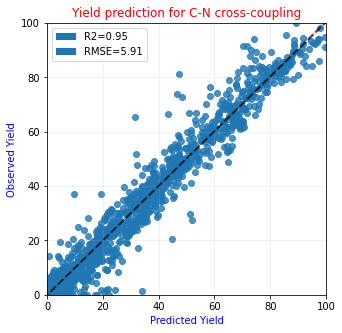

In [32]:
# Plot predicted and observed yields
plt.figure(figsize=(5,5))
sns.regplot(x=predicted_yield_all_feature, y=y_test,line_kws={"lw":2,'ls':'--','color':'black',"alpha":0.7})
plt.xlabel('Predicted Yield', color='blue')
plt.ylabel('Observed Yield', color ='blue')
plt.xlim(0,100)
plt.ylim(0,100)
plt.title("Yield prediction for C-N cross-coupling", color='red')
plt.grid(alpha=0.2)
R2_all = mpatches.Patch(label="R2={:04.2f}".format(R2_all))
RMSE_all = mpatches.Patch(label="RMSE={:4.2f}".format(RMSE_all))
plt.legend(handles=[R2_all, RMSE_all])

<div style= " border-style:dotted;text-align:left;color:blue;font-size:25px;border-radius: 10px;padding: 20px 20px;">
3. Prediction of Enantioselectivity
</div>


<div>
    <img src = "Enantioselective.JPG", width = "500">
  </div>
    
  Reference 1: [Zahrt et al ](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6417887/)  
  Reference 2: [Sandfort et al ](https://www.sciencedirect.com/science/article/pii/S2451929420300851) 

In [33]:
Enantioselective = pd.read_csv('https://raw.githubusercontent.com/gashawmg/Avalon-fingerprints-for-machine-learning/main/Denmark_input_data.csv')
Enantioselective.head()

,Catalyst,Imine,Thiol,Output
0,O=P1(O)OC2=C(C3=CC=CC=C3)C=C4C(C=CC=C4)=C2C5=C...,O=C(C1=CC=CC=C1)/N=C/C2=CC=CC=C2,SC1=CC=CC=C1,1.179891
1,O=P1(O)OC2=C(C3=CC=CC=C3)C=C4C(C=CC=C4)=C2C5=C...,O=C(C1=CC=CC=C1)/N=C/C2=CC=CC=C2,CCS,0.501759
2,O=P1(O)OC2=C(C3=CC=CC=C3)C=C4C(C=CC=C4)=C2C5=C...,O=C(C1=CC=CC=C1)/N=C/C2=CC=CC=C2,SC1CCCCC1,0.650584
3,O=P1(O)OC2=C(C3=CC=CC=C3)C=C4C(C=CC=C4)=C2C5=C...,O=C(C1=CC=CC=C1)/N=C/C2=CC=CC=C2,SC1=CC=C(OC)C=C1,1.238109
4,O=P1(O)OC2=C(C3=CC=CC=C3)C=C4C(C=CC=C4)=C2C5=C...,O=C(C1=CC=CC=C1)/N=C/C2=CC=C(C(F)(F)F)C=C2,SC1=CC=CC=C1,1.179891


In [34]:
# Calculate fingerprints for reactants
catalyst_fpts =  Calculate_Avfps(Enantioselective['Catalyst'], 2048)
imine_fpts =  Calculate_Avfps(Enantioselective['Imine'], 1024)
thiol_fpts =  Calculate_Avfps(Enantioselective['Thiol'], 1024)

100%|██████████| 1075/1075 [00:00<00:00, 3910.09it/s]


In [35]:
# Concatenate fingerprints of starting materials
concatenated_fpts = np.concatenate([catalyst_fpts,imine_fpts,thiol_fpts],axis=1)
concatenated_fpts.shape

(1075, 4096)

In [36]:
# Put them in a dataframe
Enan_concatenated_df = pd.DataFrame(concatenated_fpts,columns=['Col_A_{}'.format(i + 1) for i in range(concatenated_fpts.shape[1])])
Enan_concatenated_df

,Col_A_1,Col_A_2,Col_A_3,Col_A_4,Col_A_5,Col_A_6,Col_A_7,Col_A_8,Col_A_9,Col_A_10,...,Col_A_4087,Col_A_4088,Col_A_4089,Col_A_4090,Col_A_4091,Col_A_4092,Col_A_4093,Col_A_4094,Col_A_4095,Col_A_4096
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1071,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1072,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1073,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
Enan_concatenated_df.shape

(1075, 4096)

In [38]:
# Random forest model for enantioselective reaction
model_rf_enan = RandomForestRegressor(random_state=42)

# start time
start = time.time()

# from Sklearn -shuffle and split data 
cv = ShuffleSplit(n_splits=10, test_size = 0.441, random_state=42)

scoring = ['r2','neg_mean_absolute_error']
scores_enan = cross_validate(model_rf_enan, Enan_concatenated_df,  Enantioselective.Output, scoring=scoring, cv=cv)


print(scores_enan)
# wait for 3 seconds

time.sleep(3)
# get the end time
end = time.time()

# get the execution time
total_time = end - start
print('Total time required:', round(total_time, 2), 'seconds') # takes about 19 seconds

{'fit_time': array([4.38293743, 4.29015732, 4.46515226, 4.44599581, 4.26526356,
       4.19483566, 4.34330988, 4.2682538 , 4.28397322, 4.38147736]), 'score_time': array([0.05332708, 0.05363035, 0.09592772, 0.05263495, 0.05208302,
       0.05239773, 0.05442858, 0.05398941, 0.06194401, 0.05829239]), 'test_r2': array([0.90705316, 0.91493223, 0.91442174, 0.90377117, 0.89953987,
       0.90361321, 0.89020908, 0.89501053, 0.89632396, 0.91219771]), 'test_neg_mean_absolute_error': array([-0.14157402, -0.13957821, -0.14215863, -0.14813604, -0.15217813,
       -0.13714181, -0.14863539, -0.1487419 , -0.15457277, -0.14704008])}
Total time required: 46.93 seconds


In [39]:
# Mean values of tenfold cross-validation values of R^2 and MAE

print("R^2 :", round(np.mean(scores_enan['test_r2']), 3))
print("MAE :", round(np.mean(-scores_enan['test_neg_mean_absolute_error']), 3))

R^2 : 0.904
MAE : 0.146


 [Sandfort et al ](https://www.sciencedirect.com/science/article/pii/S2451929420300851) 
<div>
   <img src = "Enantioselective_graph.JPG",align ="left", width = "400"/>
 </div>


In [40]:
# Train-test split
X_train_enan, X_test_enan, y_train_enan, y_test_enan = train_test_split(Enan_concatenated_df, Enantioselective.Output, 
                                                test_size = 0.441, shuffle=True,random_state=42)

In [41]:
# Model training and prediction
# All the features are used
model_enan = RandomForestRegressor(random_state=42)
model_enan.fit(X_train_enan,y_train_enan)
predicted_yield_enan = model_enan.predict(X_test_enan)

In [42]:
# Calculate root-mean-squared error (RMSE) & coefficient of determination
# Model performance using MAE
MAE_enan = mean_absolute_error(y_test_enan, predicted_yield_enan)
print('MAE:', round(MAE_enan,3))
R2_enan = r2_score(y_test_enan, predicted_yield_enan)
print('R2: ', round(R2_enan,2))

MAE: 0.142
R2:  0.91


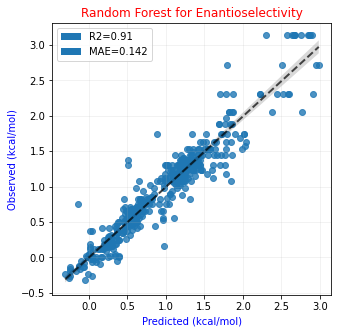

In [43]:
# Plot predicted and observed yields
plt.figure(figsize=(5,5))
sns.regplot(x=predicted_yield_enan, y=y_test_enan,line_kws={"lw":2,'ls':'--','color':'black',"alpha":0.7})
plt.xlabel('Predicted (kcal/mol)', color='blue')
plt.ylabel('Observed (kcal/mol)', color ='blue')
plt.title("Random Forest for Enantioselectivity", color='red')
plt.grid(alpha=0.2)
R2_enan = mpatches.Patch(label="R2={:04.2f}".format(R2_enan))
MAE_enan = mpatches.Patch(label="MAE={:4.3f}".format(MAE_enan))
plt.legend(handles=[R2_enan, MAE_enan])

<div style="text-align:left;color:blue;font-size:25px;border-radius: 10px;padding: 20px 20px;"><strong>Practice Problems</strong></div>

1. Use any of the other molecular fingerprints that we calculated in the previous [video](https://www.youtube.com/watch?v=-oHqQBUyrQ0), and calculate the molecular fingerprints of each of the three datasets that we used in this video.
2. Use a Random Forest model and apply a 10-fold cross-validation with 70% of the data for the training and 30% for testing. 
3. Compare your results with the results of Avalon fingerprints  

<div style="text-align:left;color:green;font-size:25px;border-radius: 10px;padding: 20px 20px;"><strong>Summary:</strong></div>
Using Avalon fingerprints as an example, we have developed predictive models for three different types of chemistry problems, HOMO-LUMO energy gap, yield and enantioselective reactions. Hopefully, in the next video, I will show you how to combine results obtained from machine learning and molecular docking to identify potentially active compounds. Stay tuned!